<a href="https://colab.research.google.com/github/ernestojr-7/Classificacao-com-pytorch/blob/main/Classificacao_com_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color = 40E0D0>Montando drive com dataset

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
main_dir = '/content/drive/MyDrive/datasets'
os.chdir(main_dir)

Mounted at /content/drive


# <font color = 40E0D0>Instalando e importando bibliotecas

In [30]:
#import urllib.request
from PIL import Image,ImageStat
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

import torchvision
import torch
import torch.nn as nn
from torch.utils.data import  DataLoader
import torchvision.transforms as transforms
import torch.functional as F
import torch.optim as optim

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics

import random
from tqdm.notebook import tqdm
import time

# <font color = 40E0D0>Definindo hiperparâmetros e dispositivo de Hardware

In [4]:
# Configurando hiperparâmetros.
args = {
    'epoch_num': 10,     # Número de épocas.
    'lr': 1e-3,           # Taxa de aprendizado.
    'weight_decay': 1e-3, # Penalidade L2 (Regularização).
    'batch_size': 8,     # Tamanho do batch.
}

# Definindo dispositivo de hardware
if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


In [5]:
# dataset transformation
transform = transforms.Compose([transforms.Grayscale(num_output_channels=3),
                                transforms.Resize((300,300)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225])
                            ])

# <font color = 40E0D0>Método para carregar Dataset

In [6]:
def CarregaImagem(imagem):
  return Image.open(imagem)

In [7]:
# carrega Dataset
from torch.utils.data import Dataset

from typing import Any,Tuple

class LoadDataset(Dataset):
    def __init__(self,dir,transform=None,target_transform=None,loader = None):
        self.main_dir = dir
        self.transform = transform
        self.target_transform = target_transform
        self.classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        self.classes.sort()
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.instances = self.make_instances()
        self.loader = loader
        if loader is None:
            self.loader = lambda x: Image.open(x)

    def make_instances(self):
        instances = []
        for target_class in sorted(self.class_to_idx.keys()):
                class_index = self.class_to_idx[target_class]
                target_dir = os.path.join(self.main_dir, target_class)
                for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
                    for fname in sorted(fnames):
                        path = os.path.join(root, fname)
                        item = path, class_index
                        instances.append(item)
                  
        return instances
    def __getitem__(self,index:int) -> Tuple[Any,Any]:
        path, target = self.instances[index]
        instance = self.loader(path)
        if self.transform is not None:
            instance = self.transform(instance)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return instance,target
    def __len__(self) -> int:
        return len(self.instances)


In [8]:
def plot_confusion_matrix(pred_list, rotulo_list):
    cm = metrics.confusion_matrix(rotulo_list, pred_list)
    sn.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False);
    plt.xlabel("classificação predita")
    plt.ylabel("classificação real")
    plt.savefig('matriz_de_confusao.pdf', 
           dpi=300)

# <font color = 40E0D0>Funções para treino e validação

In [26]:
def treino(train_loader, net, epoch, criterion, optimizer):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  # Training mode
  model.to(device)
  net.train()

  lloss  = []
  lacc = []
  l_pred, l_true = [], []
  for _, batch in enumerate(tqdm(train_loader)):
    # dado = x e rotulo = y
    dado, rotulo = batch
    
    # Cast do dado na GPU
    dado = dado.to(device)
    rotulo = rotulo.to(device)
    
    # Forward
    pred = net(dado)
    loss = criterion(pred, rotulo)
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    lloss.append(loss.item())
          
  # lacc = np.asarray(lacc)
  # lloss = np.asarray(lloss)
  # pred_list  = np.asarray(l_pred).ravel()
  # rotulo_list  = np.asarray(l_true).ravel()
  
  # print('______________________________________________________________')
  # print(f'Epoch {epoch}, TRAIN ---> Loss: {np.mean(lloss)})')
  # # print('______________________________________________________________')
  return np.mean(lloss)
  
    

In [27]:
def validate(val_loader, net, criterion, epoch):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
  # Evaluation mode
  model.to(device)
  net.eval()
 
  lloss  = []
  lacc = []
  lprec, lrec = [], []
  l_pred, l_true = [], []
  with torch.no_grad(): 
    for _, batch in enumerate(tqdm(val_loader)):

        # dado = x e rotulo = y
        dado, rotulo = batch
        
        # Cast do dado na GPU
        dado = dado.to(device)
        rotulo = rotulo.to(device)
        
        # Forward
        pred = net(dado)
        loss = criterion(pred, rotulo)
        lloss.append(loss.cpu().item())

        y_pred = pred.argmax(dim=1).cpu()         
        l_true = l_true + rotulo.tolist()
        l_pred = l_pred + y_pred.tolist()

        acc = metrics.accuracy_score(rotulo.cpu(),y_pred.cpu())
        lacc.append(acc)
        prec = metrics.precision_score(rotulo.cpu(), y_pred.cpu(), average='micro')
        lprec.append(prec)
        rec = metrics.recall_score(rotulo.cpu(), y_pred.cpu(), average='micro')
        lrec.append(rec)


  # print('______________________________________________________________')
  # print(f'Epoch {epoch}, VALIDATE ---> Loss: {np.mean(lloss)} +/- {np.std(lloss)}, Acc:{np.mean(lacc)}, Prec: {np.mean(prec)}, Rec: {np.mean(rec)} \n')
  # print('______________________________________________________________')
  
  return np.mean(lloss), np.mean(lacc), prec, rec, l_true, l_pred
    

# <font color = 40E0D0>Carrega Dataset e faz split do mesmo

In [ ]:
!pwd
!ls

In [12]:
# considerando que cada pasta em um diretorio e uma classe
dataset = LoadDataset('./', transform=transform)
len(dataset)

2000

In [13]:
# treino 80% validacao 20%
dataset_train, dataset_val= train_test_split(dataset, test_size = 0.20, shuffle = True)

# <font color = 40E0D0>Rotina de treino e validação

In [28]:
def routine_train(model, dataset_train, dataset_val, n_epoch, criterion, opt):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # TREINO E VALIDACAO
    model.to(device)  
        
    ultima_acc  = 0.0 
    epoch = 0   

    dl_train = torch.utils.data.DataLoader(dataset_train,batch_size = args['batch_size'])
    dl_val   = torch.utils.data.DataLoader(dataset_val,batch_size = args['batch_size'])
    # dl_test  = torch.utils.data.DataLoader(dataset_test,batch_size =args['batch_size'])

    lepoca = []
    lacc  = []
    lloss = []
    lrec  = []
    lprecision = []

    while epoch < (n_epoch):
        since = time.time()
        # treino
        train_loss = treino(dl_train, model, epoch, criterion,opt)
        # validacao
        val_loss, val_acc, prec, rec, l_true, l_pred = validate(dl_val, model, criterion, epoch)

        lepoca.append(epoch)
        lacc.append(val_acc)
        lloss.append(val_loss)
        lprecision.append(prec)
        lrec.append(rec)

        epoch+=1

        print("Epoch:{}/{}..".format(epoch+1, n_epoch),
              "Train Loss: {:.3f}..".format(train_loss),
              "Val Loss: {:.3f}..".format(val_loss),
              "Val Acc:{:.3f}..".format(val_acc),
              "Val Prec:{:.3f}..".format(prec),
              "Val Rec:{:.3f}..".format(rec),
              "Time: {:.2f}m".format((time.time()-since)/60))
        # definir criterio de parada

    finalResultsMeans = {"Acc": np.mean(lacc), "Prec": np.mean(lprecision), "Rec": np.mean(lrec), "Loss": np.mean(lloss)}
    print("\n---------------------------------------Final Results---------------------------------------")
    print("Mean: ", finalResultsMeans)
    plot_confusion_matrix(l_true, l_pred)
    return lepoca, lloss, lacc

# <font color = 40E0D0>Ajuste fino do modelo escolhido

In [15]:
model = torchvision.models.resnet50(pretrained=True)
# criterion = nn.CrossEntropyLoss().to(args['device'])
# optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args['weight_decay'])

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [16]:
# verificar arquitetura do modelo para ajuste fino
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
model.fc = nn.Linear(2048,4)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# <font color = 40E0D0>Treina e valida o modelo

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:2/10.. Train Loss: 0.279.. Val Loss: 0.388.. Val Acc:0.882.. Val Prec:0.750.. Val Rec:0.750.. Time: 0.60m


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:3/10.. Train Loss: 0.173.. Val Loss: 0.353.. Val Acc:0.885.. Val Prec:0.875.. Val Rec:0.875.. Time: 0.61m


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:4/10.. Train Loss: 0.167.. Val Loss: 0.427.. Val Acc:0.868.. Val Prec:0.750.. Val Rec:0.750.. Time: 0.62m


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:5/10.. Train Loss: 0.162.. Val Loss: 0.393.. Val Acc:0.877.. Val Prec:0.750.. Val Rec:0.750.. Time: 0.62m


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:6/10.. Train Loss: 0.094.. Val Loss: 0.388.. Val Acc:0.887.. Val Prec:0.750.. Val Rec:0.750.. Time: 0.62m


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:7/10.. Train Loss: 0.076.. Val Loss: 0.414.. Val Acc:0.900.. Val Prec:0.875.. Val Rec:0.875.. Time: 0.63m


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:8/10.. Train Loss: 0.115.. Val Loss: 0.399.. Val Acc:0.882.. Val Prec:0.750.. Val Rec:0.750.. Time: 0.63m


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:9/10.. Train Loss: 0.085.. Val Loss: 0.336.. Val Acc:0.897.. Val Prec:0.875.. Val Rec:0.875.. Time: 0.63m


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:10/10.. Train Loss: 0.107.. Val Loss: 0.518.. Val Acc:0.875.. Val Prec:0.625.. Val Rec:0.625.. Time: 0.63m


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:11/10.. Train Loss: 0.071.. Val Loss: 0.341.. Val Acc:0.910.. Val Prec:0.875.. Val Rec:0.875.. Time: 0.63m

---------------------------------------Final Results---------------------------------------
Mean:  {'Acc': 0.8865000000000001, 'Prec': 0.7875, 'Rec': 0.7875, 'Loss': 0.39570083079487084}


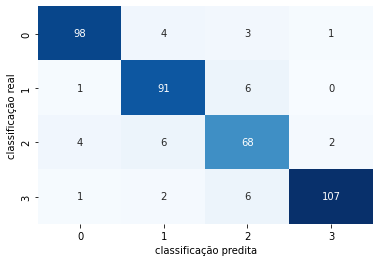

In [31]:
# rotina de treino e validacao
epoca, erro, acuracia = routine_train(model, dataset_train, dataset_val, 10, criterion, optimizer)

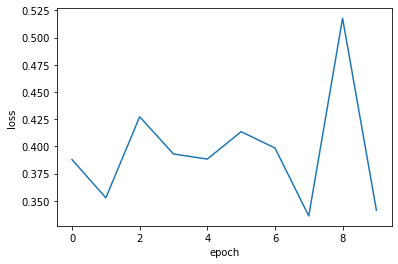

In [32]:
# loss VS epoca
plt.plot(epoca, erro)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

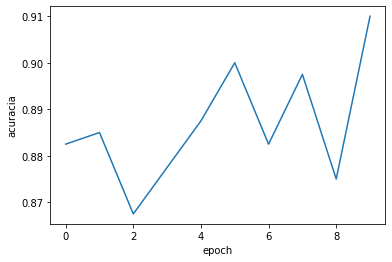

In [33]:
# acc VS epoca
plt.plot(epoca, acuracia)
plt.xlabel('epoch')
plt.ylabel('acuracia')
plt.show()